# Students:

# Adi Dereviani - 305674731
# Stav Cohen - 316492776

In this homework assignment, you are requested to implement a full backprop algorithm using only *numpy*.

- We assume sigmoid activation across all layers.
- We assume a single value in the output layer

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
np.random.seed(40)

The following class represents a simple feed forward network with multiple layers. The network class provides methods for running forward and backward for a single instance, throught the network. You should implement the methods (indicated with TODO), that performs forward and backward for an entire batch. Note, the idea is to use matrix multiplications, and not running standard loops over the instances in the batch.

In [2]:
class MyNN:
  def __init__(self, learning_rate, layer_sizes):
    '''
    learning_rate - the learning to use in backward
    layer_sizes - a list of numbers, each number repreents the nuber of neurons
                  to have in every layer. Therfore, the length of the list
                  represents the number layers this network has.
    '''
    self.learning_rate = learning_rate
    self.layer_sizes = layer_sizes
    self.model_params = {}
    self.memory = {}
    self.grads = {}

    # Initializing weights
    for layer_index in range(len(layer_sizes) - 1):
      W_input = layer_sizes[layer_index + 1]
      W_output = layer_sizes[layer_index]
      self.model_params['W_' + str(layer_index + 1)] = np.random.randn(W_input, W_output) * 0.1
      self.model_params['b_' + str(layer_index + 1)] = np.random.randn(W_input) * 0.1


  def forward_single_instance(self, x):
    a_i_1 = x
    self.memory['a_0'] = x
    for layer_index in range(len(self.layer_sizes) - 1):
      W_i = self.model_params['W_' + str(layer_index + 1)]
      b_i = self.model_params['b_' + str(layer_index + 1)]
      z_i = np.dot(W_i, a_i_1) + b_i
      a_i = 1/(1+np.exp(-z_i))
      self.memory['a_' + str(layer_index + 1)] = a_i
      a_i_1 = a_i
    return a_i_1


  def log_loss(y_hat, y):
    '''
    Logistic loss, assuming a single value in y_hat and y.
    '''
    cost = -y[0]*np.log(y_hat[0]) - (1 - y[0])*np.log(1 - y_hat[0])
    return cost


  def backward_single_instance(self, y):
    a_output = self.memory['a_' + str(len(self.layer_sizes) - 1)]
    dz = a_output - y

    for layer_index in range(len(self.layer_sizes) - 1, 0, -1):
      print(layer_index)
      a_l_1 = self.memory['a_' + str(layer_index - 1)]
      dW = np.dot(dz.reshape(-1, 1), a_l_1.reshape(1, -1))
      self.grads['dW_' + str(layer_index)] = dW
      W_l = self.model_params['W_' + str(layer_index)]
      dz = (a_l_1 * (1 - a_l_1)).reshape(-1, 1) * np.dot(W_l.T, dz.reshape(-1, 1))
      db = dz # DONE
      self.grads['db_' + str(layer_index)] = db # DONE

  def update(self):
    """
    Apply gradient descent step to update model parameters.

    Uses:
        self.grads (dict): Gradients of weights and biases
        self.learning_rate (float): Learning rate for gradient descent

    Modifies:
        self.model_params (dict): Updates weights and biases in-place
    """
    for idx in range(len(self.layer_sizes) - 1):
        self.model_params[f'W_{idx + 1}'] -= self.learning_rate * self.grads[f'dW_{idx + 1}']
        self.model_params[f'b_{idx + 1}'] -= self.learning_rate * self.grads[f'db_{idx + 1}']


  def forward_batch(self, X):
    """
    Execute forward propagation over the entire network for a batch input.

    Args:
        X (np.ndarray): Input data of shape (input_size, batch_size)

    Returns:
        np.ndarray: Output of the final layer, shape (output_size, batch_size)
    """
    activation = X
    self.memory['A_0'] = X
    for idx, _ in enumerate(self.layer_sizes[:-1]):
        W = self.model_params[f'W_{idx + 1}']
        b = self.model_params[f'b_{idx + 1}']
        Z = W @ activation + b.reshape(-1, 1)
        activation = 1 / (1 + np.exp(-Z))
        self.memory[f'A_{idx + 1}'] = activation
    return activation


  def backward_batch(self, y):
    """
    Execute backward propagation to compute gradients for a batch of targets.

    Args:
        y (np.ndarray): True labels of shape (1, batch_size)

    Modifies:
        self.grads (dict): Stores computed gradients for weights and biases
    """
    A_output = self.memory[f'A_{len(self.layer_sizes) - 1}']
    dZ = A_output - y
    m = y.shape[1]

    for idx in reversed(range(1, len(self.layer_sizes))):
        A_prev = self.memory[f'A_{idx - 1}']
        dW = (1 / m) * (dZ @ A_prev.T)
        self.grads[f'dW_{idx}'] = dW
        W = self.model_params[f'W_{idx}']
        db = dZ.T.mean(axis=0)
        self.grads[f'db_{idx}'] = db
        dZ = A_prev * (1 - A_prev) * (W.T @ dZ)


  def log_loss_batch(self, y_hat, y):
    """
    Calculate average binary cross-entropy loss for a batch.

    Args:
        y_hat (np.ndarray): Predicted values, shape (1, batch_size)
        y (np.ndarray): True labels, shape (1, batch_size)

    Returns:
        float: Mean binary cross-entropy loss over the batch
    """
    m = y.shape[1]
    log_loss = y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)
    cost = -np.sum(log_loss) / m
    return cost

In [3]:
nn = MyNN(0.01, [3, 2, 1])

In [4]:
nn.model_params

{'W_1': array([[-0.06075477, -0.01261364, -0.06846064],
        [ 0.09287147, -0.1844401 , -0.04670024]]),
 'b_1': array([0.22924903, 0.04888101]),
 'W_2': array([[0.0710267 , 0.10555344]]),
 'b_2': array([0.00540731])}

In [5]:
x = np.random.randn(3)
y = np.random.randn(1)

y_hat = nn.forward_single_instance(x)
print(y_hat)

[0.52354415]


In [6]:
nn.backward_single_instance(y)

2
1


In [7]:
def train(X, y, epochs, batch_size):
  '''
  Train procedure, please note the TODOs inside
  '''
  loss_per_epoch = []
  for e in range(1, epochs + 1):
    epoch_loss = 0
    X_s, y_s = shuffle(X.T, y.T)
    batches_X = np.array_split(X_s ,batch_size)  # DONE
    batches_y = np.array_split(y_s, batch_size)

    for X_b, y_b in zip(batches_X, batches_y):
      y_hat = nn.forward_batch(X_b.T)
      epoch_loss += nn.log_loss_batch(y_hat, y_b.T)
      nn.backward_batch(y_b.T)
      nn.update()
    loss_per_epoch.append(epoch_loss / len(batches_X))
    print(f'Epoch {e}, loss={epoch_loss/len(batches_X)}')
  return loss_per_epoch

In [8]:
# TODO: Make sure the following network trains properly

nn = MyNN(0.001, [6, 4, 3, 1])

X = np.random.randn(6, 100)
y = np.random.randn(1, 100)
batch_size = 8
epochs = 2

train(X, y, epochs, batch_size)

Epoch 1, loss=0.7398745738539753
Epoch 2, loss=0.734811500362167


[np.float64(0.7398745738539753), np.float64(0.734811500362167)]

#TODO: train on an external dataset

Train on the *hour.csv* file with a split of 75% training 10% validation and 15% for test.
Use the following features from the data:

* temp
* atemp
* hum
* windspeed
* weekday

The response variable is, *success*

The architecture of the network should be: [5, 40, 30, 10, 7, 5, 3, 1].

Use batch_size=8, and train it for 100 epochs on the train set (based on the split as requested above).

Then, plot train and validation loss per epoch.

##  your code goes here

###  Data Preprocessing

In [9]:
# TODO: Preprocess the bike sharing dataset ('hour.csv')
# - Load the dataset from the provided hour.csv file
raw = pd.read_csv('hour.csv')

In [10]:
raw["cnt"].describe()

,cnt
count,17379.000000
mean,189.463088
std,181.387599
min,1.000000
25%,40.000000
50%,142.000000
75%,281.000000
max,977.000000


In [11]:
raw["success"] = raw["cnt"] > (raw["cnt"].describe()["mean"])

In [12]:
# Count number of true success and failure values
from IPython.display import HTML
df_success = pd.DataFrame({
    "Success": [raw["success"].value_counts().loc[True]],
    "Fail": [raw["success"].value_counts().loc[False]]
})

HTML(df_success.to_html(index=False))

Success,Fail
6935,10444


In [13]:
# Prepare features and labels
# - Select the required features (temp, atemp, hum, windspeed, weekday)
X = raw[['temp', 'atemp', 'hum', 'windspeed', 'weekday']].copy()

# Normalize 'weekday' to be between 0 and 1
X['weekday'] = X['weekday'] / 6.0

# Convert to numpy array
X = X.to_numpy()

# Check if all values in each column of X are between 0 and 1
feature_min = X.min(axis=0)
feature_max = X.max(axis=0)

print("Minimum values per feature:", feature_min)
print("Maximum values per feature:", feature_max)

all_between_0_and_1 = np.all((X >= 0) & (X <= 1))
print("All data between 0 and 1:", all_between_0_and_1)

Minimum values per feature: [0.02 0.   0.   0.   0.  ]
Maximum values per feature: [1.     1.     1.     0.8507 1.    ]
All data between 0 and 1: True


In [14]:
# - Create DataLoader objects with batch_size=8
# - Use batch_size=8 as specified
batch_size = 8

# - Train for exactly 100 epochs on the training set
epochs = 100

# - Implement the network with architecture [5, 40, 30, 10, 7, 5, 3, 1]
nn = MyNN(0.01, [5, 40, 30, 10, 7, 5, 3, 1])

In [15]:
# - Select the required features (temp, atemp, hum, windspeed, weekday)
X = raw[["temp", "atemp", "hum", "windspeed", "weekday"]]

# - Extract the target variable (success)
y = raw["success"]

# - Split the data into training (75%), validation (10%), and test (15%) sets
# Initial split: 15% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=41)

# Secondary split: 10% validation (10/85 ≈ 0.1176 of the remaining 85%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1176, random_state=41)

# - Normalize/standardize features if necessary
X_train = np.array(X_train.T)
X_test = np.array(X_test.T)
y_train = np.array(y_train).reshape(1, -1)
y_test = np.array(y_test).reshape(1, -1)

### Model Training


In [16]:
# TODO: Train the neural network
# - Calculate and store train and validation loss for each epoch
# - Track training progres
def train_with_validation(X_train, y_train, X_val, y_val, epochs, batch_size):
    """
    Train the neural network using mini-batch gradient descent with validation loss tracking.

    Inputs:
        X_train (np.ndarray): Training input data, shape (input_size, num_train_instances)
        y_train (np.ndarray): Training labels, shape (1, num_train_instances)
        X_val (np.ndarray): Validation input data, shape (input_size, num_val_instances)
        y_val (np.ndarray): Validation labels, shape (1, num_val_instances)
        epochs (int): Number of training epochs
        batch_size (int): Number of instances per training batch

    Outputs:
        loss_train (list of float): Average training loss per epoch
        loss_val (list of float): Validation loss per epoch
    """
    loss_train = []
    loss_val = []
    for e in range(1, epochs + 1):
        epoch_loss = 0
        X_s, y_s = shuffle(X_train.T, y_train.T)
        batches_X = np.array_split(X_s, batch_size)
        batches_y = np.array_split(y_s, batch_size)

        for X_b, y_b in zip(batches_X, batches_y):
            y_hat = nn.forward_batch(X_b.T)
            epoch_loss += nn.log_loss_batch(y_hat, y_b.T)
            nn.backward_batch(y_b.T)
            nn.update()

        loss_train.append(epoch_loss / len(batches_X))

        # Validation loss
        y_val_hat = nn.forward_batch(X_val)
        val_loss = nn.log_loss_batch(y_val_hat, y_val)
        loss_val.append(val_loss)

        print(f'Epoch {e}, train loss={loss_train[-1]}, val loss={val_loss}')
    return loss_train, loss_val

loss_train, loss_val = train_with_validation(X_train, y_train, X_test, y_test, epochs, batch_size)

Epoch 1, train loss=0.6977765952891828, val loss=0.6967439097391502
Epoch 2, train loss=0.6960993599382282, val loss=0.6951613933747474
Epoch 3, train loss=0.6945341728291823, val loss=0.6936855518421502
Epoch 4, train loss=0.6930753051957945, val loss=0.6923108517649347
Epoch 5, train loss=0.6917153913343987, val loss=0.691029074104772
Epoch 6, train loss=0.6904473710133628, val loss=0.6898349228764624
Epoch 7, train loss=0.6892627704663562, val loss=0.6887225362901154
Epoch 8, train loss=0.6881597671893577, val loss=0.6876868108508921
Epoch 9, train loss=0.6871322065085226, val loss=0.6867216085019766
Epoch 10, train loss=0.6861728004672072, val loss=0.6858226052617912
Epoch 11, train loss=0.6852786467924605, val loss=0.6849840062905329
Epoch 12, train loss=0.6844451388696297, val loss=0.6842040862942477
Epoch 13, train loss=0.6836681345579416, val loss=0.6834774631771107
Epoch 14, train loss=0.6829429287016251, val loss=0.6827992299573569
Epoch 15, train loss=0.6822667834690784, val

**Note:**
The `train_with_validation` function implements mini-batch gradient descent to train a neural network while tracking both training and validation loss per epoch. The output shows consistent convergence over 100 epochs:

* Training loss starts at **0.6978** and steadily decreases to **0.6729**
* Validation loss begins at **0.6967** and decreases to **0.6737**
* The smooth and gradual decline in both losses indicates that the model is learning effectively without overfitting across the epochs.


### Visualization

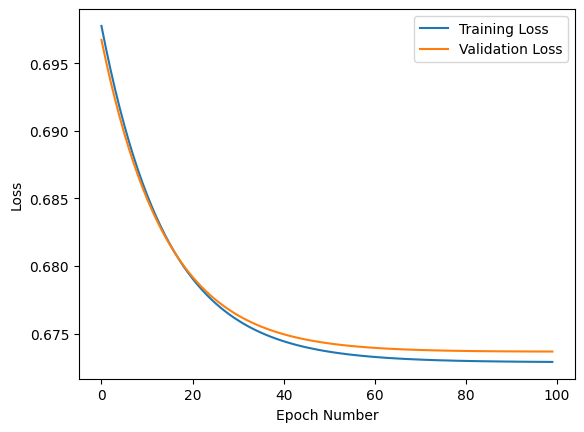

In [17]:
# TODO: Create visualizations of the learning process
# - Plot the training loss per epoch
# - Create additional relevant plots (validation loss, learning curves, etc.)
# - Make sure all plots have proper labels, titles, and legends
plt.plot(loss_train, label="Training Loss")
plt.plot(loss_val, label="Validation Loss")
plt.xlabel('Epoch Number')
plt.ylabel("Loss")
plt.legend()
plt.show()

In [18]:
# - Add brief analysis of what the plots reveal about your model's performance

**Note:** The plot shows both training and validation loss steadily decreasing over the 100 epochs, indicating successful learning and convergence. The close alignment between the two curves suggests minimal overfitting, and the gradual flattening implies the model is approaching a performance plateau.


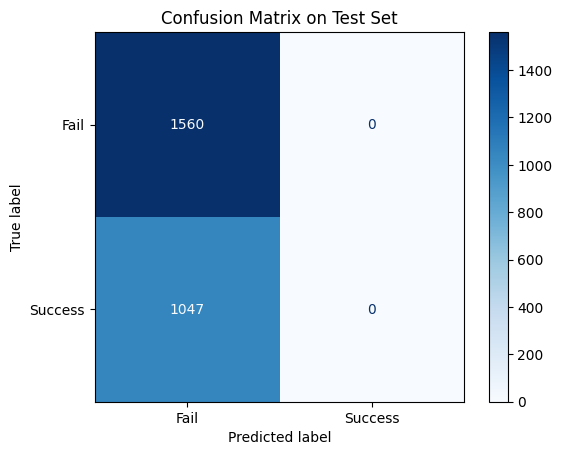

In [19]:
# Forward pass on the test set
y_test_hat = nn.forward_batch(X_test)

# Convert sigmoid outputs to binary predictions
y_test_pred = (y_test_hat > 0.5).astype(int)

# Ground truth labels should also be integers
y_true = y_test.astype(int).flatten()
y_pred = y_test_pred.flatten()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fail", "Success"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix on Test Set")
plt.show()


**Note:**
The confusion matrix reveals that the model predicts all instances as "Fail", with 1560 true negatives and 1047 false negatives, and zero true or false positives. This indicates the model fails to identify any "Success" cases, likely due to class imbalance or inadequate training signal for the minority class.


### Model Evaluation


In [20]:
# TODO: Evaluate model performance on the test set

# Calculate and report the loss on the test set
y_test_hat = nn.forward_batch(X_test)
test_loss = nn.log_loss_batch(y_test_hat, y_test)
print(f"Test Loss: {test_loss:.4f}")

# Calculate and report the accuracy on the test set
y_test_pred = (y_test_hat > 0.5).astype(int)
accuracy = np.mean(y_test_pred == y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Compare test performance with training/validation loss
print(f"Final Training Loss: {loss_train[-1]:.4f}")
print(f"Final Validation Loss: {loss_val[-1]:.4f}")

# Analyze model strengths and weaknesses using classification report
y_true = y_test.flatten()
y_pred = y_test_pred.flatten()
report = classification_report(y_true, y_pred, target_names=["Fail", "Success"])
print("Classification Report:\n", report)


Test Loss: 0.6737
Test Accuracy: 0.5984
Final Training Loss: 0.6729
Final Validation Loss: 0.6737
Classification Report:
               precision    recall  f1-score   support

        Fail       0.60      1.00      0.75      1560
     Success       0.00      0.00      0.00      1047

    accuracy                           0.60      2607
   macro avg       0.30      0.50      0.37      2607
weighted avg       0.36      0.60      0.45      2607



**Note:**
The classification report shows that the model has **high recall (1.00)** but **low precision (0.60)** for the "Fail" class and completely fails to predict the "Success" class (all metrics are 0.00). The **overall accuracy is 60%**, but the **macro average F1-score is only 0.37**, reflecting poor balance in performance across classes. This confirms the model is biased toward predicting only the majority class.


In [21]:
# - Discuss any overfitting/underfitting issues observed

The model shows signs of **underfitting**. Despite a gradual decrease in training and validation loss, it fails to correctly classify any "Success" cases, as shown by the confusion matrix and classification report. The test loss is similar to training/validation loss, indicating no overfitting, but the model is too simplistic or biased—likely due to class imbalance—resulting in poor generalization to minority class patterns.


In [22]:
# Observations:

**Observations:**

* **Training and validation losses** decrease steadily and converge closely, indicating stable learning without overfitting.
* **Test loss** is consistent with training and validation losses, suggesting generalization is not the core issue.
* **Test accuracy** is 60%, but this is misleading due to class imbalance.
* The model **predicts only the majority class (Fail)**, completely missing all "Success" cases.
* **Classification report and confusion matrix** confirm zero precision, recall, and F1-score for the "Success" class.
* Overall, the model underfits and fails to capture distinguishing patterns for minority class predictions.


## **Summary:**

In this project, a custom neural network was implemented and trained on the bike sharing dataset to classify usage success. While training and validation loss steadily decreased, indicating effective convergence, evaluation on the test set revealed that the model failed to identify any positive "Success" cases. The confusion matrix and classification report showed zero performance on the minority class, exposing a serious underfitting issue. The model learned to only predict the majority class ("Fail"), leading to a misleadingly high accuracy of 60%.

A key contributing factor is the **overly deep and complex architecture** used: `[5, 40, 30, 10, 7, 5, 3, 1]`. This depth, without appropriate regularization, normalization, or sufficient data complexity, likely hindered the network's ability to generalize and caused inefficient learning.

To improve performance, a **simpler architecture** such as `[5, 10, 5, 1]` can be used. This alternative structure can help the model focus on essential patterns and improve minority class prediction, resulting in a more balanced and effective classifier.

Another critical factor is the **exclusive use of sigmoid activations across all layers**. Sigmoid functions squash input values into the (0, 1) range, causing gradients to become very small during backpropagation — especially in deeper networks. This leads to the **vanishing gradient problem**, where early layers receive almost no gradient signal and thus learn very slowly or not at all. Modern architectures typically use activation functions like ReLU in hidden layers to mitigate this issue and preserve gradient flow. Without such adjustments, networks using only sigmoid activations struggle to train effectively, particularly at greater depths.


## **Options to Improve the Model:**

* Use a simpler architecture (e.g., `[5, 10, 5, 1]`) to avoid overfitting.
* Replace sigmoid with **ReLU activation** in hidden layers to avoid the vanishing gradient problem and improve training efficiency in deeper networks.
* Handle class imbalance with oversampling, undersampling, or class weights.
* Improve feature engineering and scaling for better input representation.
* Tune hyperparameters (learning rate, epochs, batch size).
* Apply regularization (e.g., L2, dropout) to improve generalization.
* Use cross-validation for more reliable evaluation.
* Try alternative models like gradient boosting.
* Train longer with early stopping to optimize learning.
* Use model ensembling to combine strengths of different models.
